In [2]:
import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse
import cmapPy.pandasGEXpress.subset_gctoo as sg
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [3]:
def checking_tomics_profiles(cell_name_string, cell_name, lower_doses, higher_doses, clue_sig):
    '''Creates a table that assesses the number of transcriptomic profiles given a certain dosage range and a selection of 
    cell line from the clue.io database
    
    Input:
    cell_name_string: list of strings representing cell line name
    cell_name:        list of strings of the cell lines to include
    lower_doses:      list of integers representing lower range of dosages
    higher_doses:     list of integers representing higher range of dosages
    
    Output: Tabulate table
    '''
    table = []
    for i, s in zip(cell_name, cell_name_string):
        for a,f in zip(lower_doses, higher_doses):
            row = []
            row.append(s)
            check = clue_sig[clue_sig.cell_iname.isin(i)]
            check_with_correct_dosage = check[check.pert_dose.between(a,f)].reset_index(drop=True)
            number = check_with_correct_dosage.shape[0]
            row.append([a,f])
            row.append(number)
            table.append(row)
    print(tabulate(table, headers=["Cell line Name","Dosage", "# Transcriptomic Profiles"], tablefmt="heavy_grid"))

In [4]:
def compound_moa_classes(clue_sig, compounds1_2, moas, cell_name_string, cell_name, lower_doses, higher_doses, head_num = 5):
    '''Creates a table that assesses the number of transcriptomic profiles given a certain dosage range and a selection of 
    cell line from the clue.io database
    
    Input:
    clue_sig:         metadata from all transcriptomic level 5 signatures
    compounds1_2:     combined list of compounds found in SPECS V1 and V2.
    moas:             list of strings representing a subset of MoA classes to investigatedd
    cell_name_string: list of strings representing cell line name
    cell_name:        list of strings of the cell lines to include
    lower_doses:      list of integers representing lower range of dosages
    higher_doses:     list of integers representing higher range of dosages
    head_num:         int that determines number of rows displayed by datafram
    
    Output:
    Several data frames of a length determined by head_num
    '''
    
    for i, s in zip(cell_name, cell_name_string):
        for a,f in zip(lower_doses, higher_doses):
            clue_sig = clue_sig[clue_sig.pert_id.isin(compounds1_2.CUSTOMER_ID)]
            check = clue_sig[clue_sig.cell_iname.isin(i)]
            check_with_correct_dosage = check[check.pert_dose.between(a,f)].reset_index(drop=True)
            unique_all = check_with_correct_dosage.drop_duplicates(subset=["pert_id"])
            

            # ADD SOMETHING HERE IN ORDER TO PRINT OUT THE NUMBER OF TRANCRIPTOMIC PROFILES FOR EACH MOA CLASS

            # printing MoA classes with x number of compounds targeting specific MoA class 
            print(f" \033[1m{'Cell Line(s):' : >20}\033[0m  {s}")
            print(f" \033[1m{'Dosage Range:' : >20}\033[0m  [{a},{f}]")
            print(f" \033[1m{'All Compounds Found in SPECS v1 and V2' : >20}\033[0m")
            print(unique_all.moa.value_counts().head(head_num))
            print(f'Enantiomers: {unique_all[unique_all.duplicated("Compound ID")].shape[0]}')
            chosen_MoA_classes = check_with_correct_dosage[check_with_correct_dosage.moa.isin(moas)]
            unique_chosen_MoA_classes = chosen_MoA_classes.drop_duplicates(subset=["pert_id"])
            
            # printing MoA classes with x number of compounds targeting specific MoA class (Chosen Subset)
            print(f" \033[1m{'Selected MoAS' : >20}\033[0m" )
            print(unique_chosen_MoA_classes.moa.value_counts().head(head_num))
            print(f'Enantiomers: {unique_chosen_MoA_classes[unique_chosen_MoA_classes.duplicated("Compound ID")].shape[0]}')
            print(chr(10))


In [5]:
def number_of_transcriptomics_profiles_for_moa(clue_sig, moa_names):
    ''' Gives the number of transcriptomic profiles that exist for each moa 
    class that we send.
    
    input
    clue_sig: (pandas) meta data with transcriptomic profiles. 
            Must have moa data joined.
    moa_names: List of strings with MoAs of interest
    
    output:
    - prints table with MoA name and the number of transcriptomic profiles.
    - returns the total number of profiles for list of MoAs sent in.''' 
    
    headers = ["MoA Name", "# Tomics Profiles"]
    dictionary = {}
    total = 0
    for i in moa_names:
        transcript_num = clue_sig[clue_sig.moa == i].shape[0]
        dictionary[i] = transcript_num
        total += transcript_num
    print(tabulate(dictionary.items(), headers))
    return total


In [6]:
def cell_line_corr(moas, clue_gene, clue_sig_in_SPECS, min_num):
    '''
    Produces correlation heatmap of how different cell lines' transcriptomic profiles differ
    from each other.
    
    Input:
    moas: list of moas to investigate
    clue_gene: row meta data from clue.io transcriptomic profiles
    clue_sig_in_SPECS: column meta data from clue.io transcriptomic profiles in §§§dprvd
    min_num: the least number of transcriptomic profiles necessary to include in corr analysis
    
    Output:
    - produces correlation
    - saves a png figure in PNG_Cell_Line_Investigations
    - prints the cell line and the number of transcriptomic profiles
    '''
    for MOA in moas:
        
        # choosing only landmark genes
        clue_gene["gene_id"] = clue_gene["gene_id"].astype(str)
        landmark_gene_row_ids = clue_gene["gene_id"][clue_gene["feature_space"] == "landmark"]

        # get all samples (across all cell types, doses, and other treatment conditions) with certain MoA
        profile_ids = clue_sig_in_SPECS["sig_id"][clue_sig_in_SPECS["moa"] == MOA]
        tprofiles_gctoo = parse("/scratch2-shared/erikep/level5_beta_trt_cp_n720216x12328.gctx", 
                                      cid= profile_ids, 
                                      rid = landmark_gene_row_ids)

        ### 2. copy the metadata from those samples

        # first, we need to subset all the metadata information from our larger metadata DataFrame
        # col
        tprofiles_sig_id_info = clue_sig_in_SPECS[clue_sig_in_SPECS["moa"] == MOA]

        # row 
        tprofiles_gene_id_info = clue_gene[clue_gene["feature_space"] == "landmark"]

        tprofiles_sig_id_info.set_index("sig_id", inplace=True)
        # now the data frame is indexed by sig_ids consistent with those of the data_df:
        tprofiles_sig_id_info.index

        tprofiles_gene_id_info.set_index("gene_id", inplace=True)
        # now the data frame is indexed by sig_ids consistent with those of the data_df:
        tprofiles_gene_id_info.index

        # set the relevant annotations as a col_metadata_df: 
        tprofiles_gctoo.col_metadata_df = tprofiles_sig_id_info

        # set the relevant annotations as a row_metadata_df: 
        tprofiles_gctoo.row_metadata_df = tprofiles_gene_id_info

        ### 4. From that Metadata, subset if need be

        cell_inames = tprofiles_gctoo.col_metadata_df["cell_iname"].unique()
        
        # remove cell lines that don't have more than a min_num of profiles 
        enough_cellnames = []
        for i in cell_inames:
            tprofiles_cell_line1 = tprofiles_gctoo.col_metadata_df.index[tprofiles_gctoo.col_metadata_df["cell_iname"] == i]
            if len(tprofiles_cell_line1) > min_num:
                   enough_cellnames.append(i)              

        # take mean transcriptomic profile for profiles within cell line and save in list
        all_cell_lines = []
        for i in enough_cellnames:
            # print cell lines and number of profiles that meet criteria
            tprofiles_cell_line1_ids = tprofiles_gctoo.col_metadata_df.index[tprofiles_gctoo.col_metadata_df["cell_iname"] == i]
            print(f' Cell line: {i}, #: {len(tprofiles_cell_line1_ids)}')
            
            tprofiles_cell_line1_ids = list(tprofiles_cell_line1_ids)
            # subset GCToo instance to only include these values 
            tprofiles_line1_gctoo = sg.subset_gctoo(tprofiles_gctoo, cid= tprofiles_cell_line1_ids)
            mean = tprofiles_line1_gctoo.data_df.mean(axis = 1)
            all_cell_lines.append(mean)

        # concatanate into new pandas dataframe
        broster= pd.concat(all_cell_lines,axis = 1)
        corr = broster.corr()
        matrix = np.triu(corr)
        # Plotting Results
        title_string = MOA + ": correlation between different cell lines. Min num of profiles: " + str(min_num)
        plt.figure(figsize=(16,5))
        plt.title(title_string)
        sns.set()
        sns.heatmap(corr*100,
                    annot = True,
                    fmt='.2g', 
                    xticklabels = enough_cellnames,
                    yticklabels = enough_cellnames,
                    mask = matrix)
        png_directory = "/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/PNG_Cell_Line_Investigations"
        name = png_directory + "/" + MOA +  ".png"
        plt.savefig(name)
        plt.show()

## Downloading data 

In [7]:
# metadata for clue.io data in the SPECS1&2
clue_sig_in_SPECS = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_sig_in_SPECS1&2.csv', delimiter = ",")
# identifying rows with only landmark genes
clue_gene = pd.read_csv('/home/jovyan/Tomics-CP-Chem-MoA/04_Tomics_Models/init_data_expl/clue_geneinfo_beta.txt', delimiter = "\t")
# downloading information on all of the compounds
compounds_v1v2 = pd.read_csv("/home/jovyan/Tomics-CP-Chem-MoA/data_for_models/compounds_v1v2.csv")

In [12]:
# list of different moas to investigate
erik10 = ["cyclooxygenase inhibitor", "dopamine receptor antagonist","adrenergic receptor antagonist", "phosphodiesterase inhibitor",  "HDAC inhibitor", 
             "histamine receptor antagonist","EGFR inhibitor", "adrenergic receptor agonist", "PARP inhibitor",  "topoisomerase inhibitor"]
cyc_adr = ["cyclooxygenase inhibitor", "adrenergic receptor antagonist"]
cyc_dop = ["cyclooxygenase inhibitor", "dopamine receptor antagonist"]
tian10 = ['Aurora kinase inhibitor', 'tubulin polymerization inhibitor', 'JAK inhibitor', 'protein synthesis inhibitor', 'HDAC inhibitor',
            'topoisomerase inhibitor', 'PARP inhibitor', 'ATPase inhibitor', 'retinoid receptor agonist', 'HSP inhibitor']
phosph = ["phosphodiesterase inhibitor"]

 Cell line: A375, #: 40
 Cell line: A549, #: 78
 Cell line: HT29, #: 40
 Cell line: MCF7, #: 113
 Cell line: PC3, #: 101
 Cell line: U2OS, #: 9
 Cell line: NPC, #: 108
 Cell line: HIMG001, #: 18
 Cell line: HIMG002, #: 18
 Cell line: HA1E, #: 48
 Cell line: HCC515, #: 49
 Cell line: VCAP, #: 63
 Cell line: HEPG2, #: 25
 Cell line: ASC, #: 17
 Cell line: PHH, #: 13
 Cell line: SKB, #: 17
 Cell line: HUH7, #: 13
 Cell line: SHSY5Y, #: 6
 Cell line: SKNSH, #: 6


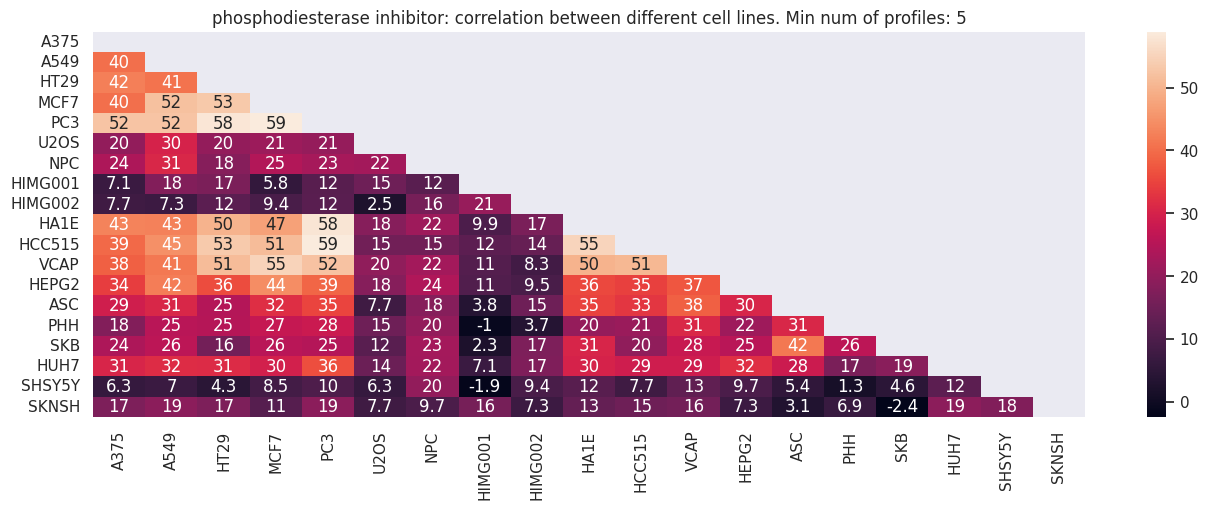

In [14]:
cell_line_corr(phosph, clue_gene, clue_sig_in_SPECS, 5)

In [15]:
total_Tomics = number_of_transcriptomics_profiles_for_moa(clue_sig_in_SPECS, cyc_adr )

MoA Name                          # Tomics Profiles
------------------------------  -------------------
cyclooxygenase inhibitor                       1184
adrenergic receptor antagonist                  517


In [17]:
single_name = ['U2OS']
subset_names = ['MCF7', 'PC3', 'A549']
lower_doses = [8, 0]
higher_doses = [12, 100]
#subset2_names = ['PC3', 'A549']
all_names = list(clue_sig_in_SPECS.cell_iname)
cell_name = [single_name, all_names]
cell_name_string = ['U2OS', "all" ]
compound_moa_classes(clue_sig_in_SPECS, compounds_v1v2, erik10, cell_name_string, cell_name, lower_doses, higher_doses, head_num = 10)

        Cell Line(s):  U2OS
        Dosage Range:  [8,12]
 All Compounds Found in SPECS v1 and V2
tubulin polymerization inhibitor              4
EGFR inhibitor                                4
protein synthesis inhibitor                   3
HSP inhibitor                                 3
dopamine receptor antagonist                  3
PARP inhibitor                                3
topoisomerase inhibitor                       2
retinoid receptor agonist                     2
mTOR inhibitor|PI3K inhibitor                 2
histone lysine methyltransferase inhibitor    2
Name: moa, dtype: int64
Enantiomers: 0
        Selected MoAS
EGFR inhibitor                  4
PARP inhibitor                  3
dopamine receptor antagonist    3
HDAC inhibitor                  2
topoisomerase inhibitor         2
adrenergic receptor agonist     2
phosphodiesterase inhibitor     1
Name: moa, dtype: int64
Enantiomers: 0


        Cell Line(s):  U2OS
        Dosage Range:  [0,100]
 All Compounds Found in